# 06: Multi-layer Neural Networks
NSC 3270 <br>
Due Tues Oct 26 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as R
R.seed(1337)

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers

## All testing / functions to quickly create networks:

In [71]:
def create_network(node_list=[2,2,1], func_list=['relu'], my_opt='adam', loss_func='sparse_categorical_crossentropy'):
    network = models.Sequential()
    for idx, arg in enumerate(node_list):
        if idx == 0:
            n_prev = arg
        elif idx == len(node_list):
            if node_list[-1] == 1 and len(func_list) == 1:
                my_func = 'sigmoid'
                loss_func = 'binary_crossentropy'
            elif len(func_list) == 1:
                my_func = 'softmax'
                loss_func = 'categorical_crossentropy'
            else:
                # E.g. you manually specified
                my_func = func_list[-1]
            network.add(layers.Dense(arg, 
                             activation=my_func, 
                             input_shape=(n_prev,)))
        else:
            network.add(layers.Dense(arg, 
                                     activation=func_list[0], 
                                     input_shape=(n_prev,)))
    
    # configure optimizer
    # sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
    network.compile(optimizer=my_opt, 
                    loss=loss_func, 
                    metrics=['accuracy', 'mse'])
    
    return network

In [39]:
def plot_model_acc(history):
    """Accuracy Plotting Function"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy As a Function of Number of Epochs Trained')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

In [40]:
# function for generating plot for Q4
# xv is array of x-values of test grid (from meshgrid)
# yv is array of y-values of test grid (from meshgrid)
# out is the output of the neural network given the test patterns
# sample0, sample1 are the training patterns from earlier

def plottest(xv, yv, out, sample0, sample1):
    # reshape out
    zv = out.reshape(xv.shape)

    # create figure
    fig = plt.figure()
    plt.contourf(xv, yv, zv, levels=xv.shape[0], cmap=plt.cm.gist_yarg)
    plt.plot(sample0[:,0], sample0[:,1], 'b+', 
             sample1[:,0], sample1[:,1], 'r+')    
    
    plt.xlabel('dim1')
    plt.ylabel('dim2')
    plt.axis('equal')
    plt.axis('square')
    xymin = -5.5; xymax = 5.5
    plt.ylim((xymin,xymax))
    plt.xlim((xymin,xymax))
    plt.show()

## Q1 (2 points)

Use the approach from HW5 to create an XOR problem, allowing for 200 training patterns per category (e.g. 400 total) and assume the same standard deviations/correlations used for HW5.  You will need to format the matrix of training patterns and the matrix of teachers to allow for the problem to be learned by a neural network using Keras.  Display your XOR problem in a figure.

In [41]:
## generate N random samples from a 2D multivariate normal distribution
##
## with mean [mx, my]
##
## with covariance matrix [[  sx*sx, r*sx*sy],
##                         [r*sx*sy,   sy*sy]]
## where sx is the standard deviation along the x dimension
## where sy is the standard deviation along the y dimension
## where r is the correlation between the dimensions
##

def gensamples(N, mx, my, sx, sy, r):
    M   = np.array([mx, my])
    Cov = np.array([[  sx*sx, r*sx*sy],
                    [r*sx*sy,   sy*sy]])
    return (R.multivariate_normal(M, Cov, size=N, check_valid='warn'))

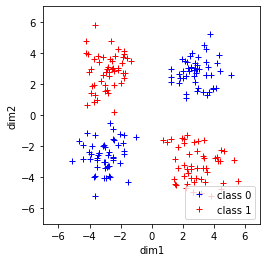

In [42]:
# classification problem used in Q1

# Bottom left
mx0 = -3.;  my0 = -3.
sx0 = 1.;  sy0 = 1.
r0 = 0.
# Top right
mx1 = 3.; my1 = 3.
#######################################################################
# Bottom right
mx3 = 3.;  my3 = -3.
sx3 = 1.; sy3 = 1.
r3 = 0.
# Top left
mx4 = -3.; my4 = 3.
#######################################################################
N = 50
sample_bl = gensamples(N, mx0, my0, sx0, sy0, r0)
sample_tr = gensamples(N, mx1, my1, sx0, sy0, r0)
sample0 = np.concatenate((sample_bl, sample_tr), axis=0)

sample_br = gensamples(N, mx3, my3, sx3, sy3, r3)
sample_tl = gensamples(N, mx4, my4, sx3, sy3, r3)
sample1 = np.concatenate((sample_br, sample_tl), axis=0)

# plot example
plt.plot(sample0[:,0],sample0[:,1],'b+',sample1[:,0],sample1[:,1],'r+')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.axis('equal')
plt.axis('square')
plt.legend(('class 0', 'class 1'), loc='lower right')
xymin = -7; xymax = 7
plt.ylim((xymin,xymax))
plt.xlim((xymin,xymax))
plt.show()

Format the training patterns and make the teachers (one_hot_labels)

In [43]:
# All training patterns

train_array = np.concatenate((sample0, sample1), axis=0)
# Verify correct shape
print(train_array.shape)
# Verify the first sample is the first entry of sample0
print(sample0[0])
print(train_array[0])
# Verify the 100th sample is the first entry of sample1
print(sample1[0])
print(train_array[100])

(200, 2)
[-4.17226488 -1.14433205]
[-4.17226488 -1.14433205]
[ 4.48134549 -4.74380821]
[ 4.48134549 -4.74380821]


In [44]:
# Create the teacher

train_labels_onehot = np.concatenate((np.zeros((N*2,1)), np.ones((N*2,1))))
print(train_labels_onehot.shape)
print(train_labels_onehot[0])
print(train_labels_onehot[100])

(200, 1)
[0.]
[1.]


## Q3 (5 points)

Create a multi-layer neural network that can learn this XOR problem using Keras.  You will need to decide the number of hidden layers and nodes per layer (and justify those choices), as well as choose an optimizer and choose a number of epochs and batch size (and justify these choices).  Hold out 20% of the training patterns for validation.  Document the iterations you did before arriving at your final answer.  Use the plots in Q3 to inform your choices. <br>
<br>
In a markdown cell, briefly document the different options you investigated (different network architectures and Keras settinsg) and why you chose the particular combinations you arrived at.

## Justifications and Iterations
1. First iteration was with a basic network of relu activation, feeding into a softmax layer, with the categorical cross entropy loss function.  Specifically, this iteration had 2 input nodes, 2 hidden nodes, and 2 output nodes (e.g. 1 output for each class).  This failed to learn the correlations, instead resulting in single smooth gradient from the top left (class 0) to the bottom right (class 1), with an accuracy below 50%.
2. The second iteration instead used 4 hidden input nodes, as the network will need to be able to draw at least 2 intersecting lines (e.g. 4 line segments if the 2 lines do not divide perfectly).  This resulted in an accuracy of 68% but still the wrong gradient as plotted from plottest()
3. This iteration determined the minimum number of nodes in the hidden layer before the network could learn the pattern.

In [45]:
network = create_network([2,15,15,2],['relu','softmax'])

print(network.summary())
print('************************************************\n')

for layer in network.layers:
    print('layer name : {} | input shape : {} | output shape : {}'.format(layer.name, layer.input.shape, layer.output.shape))
print('************************************************\n')

for layer in network.layers:
    print(layer.get_config())
print()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 15)                45        
_________________________________________________________________
dense_7 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 32        
Total params: 317
Trainable params: 317
Non-trainable params: 0
_________________________________________________________________
None
************************************************

layer name : dense_6 | input shape : (?, 2) | output shape : (?, 15)
layer name : dense_7 | input shape : (?, 15) | output shape : (?, 15)
layer name : dense_8 | input shape : (?, 15) | output shape : (?, 2)
************************************************

{'name': 'dense_6', 'trainable': True, 'batch_input_shape': (None, 2), 'd

In [46]:
# now train the network
#
# training requires training patterns (train_image_vec) and teachers (train_labels_onehot)
#
# sets # training epochs, validation (described later), and batch_size
#
# set verbose=True to see training unfold

num_epochs = 30

history = network.fit(train_array, 
                      train_labels_onehot, 
                      verbose=True, 
                      validation_split=.2, 
                      epochs=num_epochs, 
                      batch_size=40)
print('Done training!')

Train on 160 samples, validate on 40 samples
Epoch 1/30
160/160 [==============================] - 0s 3ms/sample - loss: 5.8703 - acc: 0.6250 - mean_squared_error: 1.4763 - val_loss: 15.4799 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.7630
Epoch 2/30
160/160 [==============================] - 0s 148us/sample - loss: 5.8537 - acc: 0.6250 - mean_squared_error: 1.4174 - val_loss: 13.7642 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.7453
Epoch 3/30
160/160 [==============================] - 0s 164us/sample - loss: 5.8356 - acc: 0.6250 - mean_squared_error: 1.3643 - val_loss: 12.2780 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.7245
Epoch 4/30
160/160 [==============================] - 0s 129us/sample - loss: 5.8160 - acc: 0.6250 - mean_squared_error: 1.3056 - val_loss: 11.1163 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.6950
Epoch 5/30
160/160 [==============================] - 0s 123us/sample - loss: 5.6248 - acc: 0.6250 - mean_squared_error: 1.2570 - val_loss: 9.039

## Q3 (3 points)

Create a plot of training accuracy as a function of epoch, create a plot of both the loss ('loss') and validation loss ('val_loss') on the same graph.  Test the network using a mesh grid of test patterns and display the results as a 3D graph using plottest().

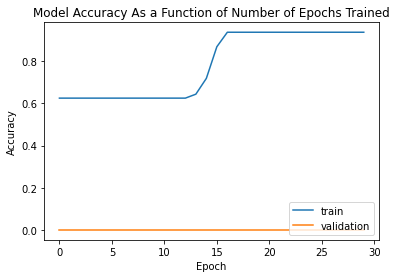

In [47]:
plot_model_acc(history)

In [48]:
# generate test pattern array for Q4

xymin = -5.5
xymax = 5.5
Npts = 25
xv, yv = np.meshgrid(np.linspace(xymin, xymax, Npts), 
                     np.linspace(xymin, xymax, Npts))
test_pats = np.concatenate((xv.reshape((Npts*Npts,1)), 
                            yv.reshape((Npts*Npts,1))), axis=1)

print(test_pats[0])
print(test_pats[1])
print(test_pats[98])
print(test_pats[99])

[-5.5 -5.5]
[-5.04166667 -5.5       ]
[ 5.04166667 -4.125     ]
[ 5.5   -4.125]


In [49]:
print(test_pats.shape)
print(xv.shape)
print(yv.shape)

(625, 2)
(25, 25)
(25, 25)


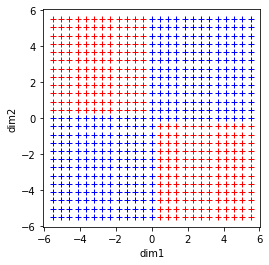

In [50]:
test_labels_onehot = [0]*test_pats.shape[0]

# plot example
for idx in range((test_pats.shape[0])):
    point = test_pats[idx,:]
    if ((point[0] < 0 and point[1] > 0) or (point[0] > 0 and point[1]<0)):
        test_labels_onehot[idx] = 1
        plt.plot(point[0],point[1],'r+')
    else:
        plt.plot(point[0],point[1],'b+')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.axis('equal')
plt.axis('square')
xymin = -5; xymax = 7.5
plt.show()

test_labels_onehot_array = np.array(test_labels_onehot).reshape((test_pats.shape[0],1))
test_labels_onehot_opened = [val[0] for val in test_labels_onehot_array]
test_labels_onehot_2D = np.array(test_labels_onehot_opened).reshape(len(test_labels_onehot_opened),1)

In [51]:
# call network.evaluate() if you have test patterns and test answers and want to know performance
results = network.evaluate(test_pats, 
                           test_labels_onehot_2D, 
                           verbose=False)

test_loss = results[0]
test_acc = results[1]

print('test_loss (MSE)     : {}'.format(test_loss))
print('test_acc (%Correct) : {}'.format(test_acc))

out = network.predict(
   test_pats, 
   batch_size = 20, 
   verbose = 0,  
   workers = 1, 
   use_multiprocessing = False)

test_loss (MSE)     : 0.5239452909469604
test_acc (%Correct) : 0.7167999744415283


In [52]:
print(out.shape)
print(sum(out[:,0]))
print(sum(out[:,1]))

(625, 2)
532.4219706654549
145.73072248883545


The issue here is that my output is 2 nodes, which are softmax, and thus it outputs 2 different probabilities.  My input is n by 2 (for x and y features).

In [53]:
plottest(xv, yv, out, sample0, sample1)

ValueError: cannot reshape array of size 1250 into shape (25,25)

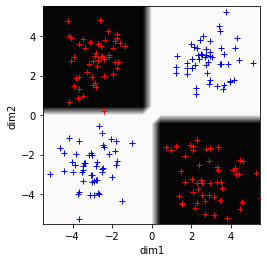

In [54]:
plottest(xv, yv, test_labels_onehot_2D, sample0, sample1)

## Full model pipeline

In [72]:
def run_pipeline(node_list=[2,2,1], func_list=['relu'], my_opt='adam', loss_func='sparse_categorical_crossentropy', num_epochs=30, my_batch=40):

    for _ in range(5):
        network = create_network(node_list, func_list, my_opt, loss_func)
        history = network.fit(train_array, 
                              train_labels_onehot, 
                              verbose=False, 
                              validation_split=.2, 
                              epochs=num_epochs, 
                              batch_size=my_batch)
        print('Done training!')
        plot_model_acc(history)

    out = network.predict(
       test_pats, 
       batch_size = my_batch, 
       verbose = 0,  
       workers = 1, 
       use_multiprocessing = False)

    plottest(xv, yv, out, sample0, sample1)
    plottest(xv, yv, test_labels_onehot_2D, sample0, sample1)
    return network, history, out

Done training!


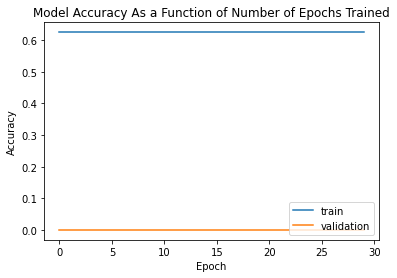

In [77]:
my_batch = 1

network4 = create_network(node_list=[2,4,4,2])
history4 = network4.fit(train_array, 
                              train_labels_onehot, 
                              verbose=False, 
                              validation_split=.2, 
                              epochs=num_epochs, 
                              batch_size=my_batch)
print('Done training!')
plot_model_acc(history4)

In [68]:
network, history, out = pipeline4 = run_pipeline(node_list=[2,4,1])

AttributeError: 'tuple' object has no attribute 'fit'

## Q4 (3 points)

Create your own classification problem for a neural network to learn.  Cannot be linearly separable, it can have as many classes as you'd like (as long as it's 2 or more).  If your problem has 2 classes, there must be more than one distribution per class. I want to see that the distribution that make up your problem have unequal variances and non-zero correlations.  Display your problem in a figure.

## Q5 (5 points)

Create a multi-layer NN that can learn your problem.  Justiyf all choices. <br>
<br>
We will be looking to see that your network is reasonably small (number of layers and number of nodes per layer) to learn our problem (e.g. its complexity must be justified).  A network with seveeral hidden layers and dozens of nodes per layer might learn your problem, but would be undoubtedly too complex to be justifiable. <br>
<br>
In a mark down cell, briefly document that different options you investiaged and why you chose the particular combinations you arrived at.

## Q6 (2 points)

Create a plot of training accuracy as a function of epoch, and create a plot of both the loss and validation loss.  Use plottest() again.  You may need to edit the given function in this case to make it work with your problem.